# 0.0 imports

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression 

## 0.1 load dataset

In [68]:
path = '/Users/raphael/Documents/repos/bank_churn'
df_raw = pd.read_csv(path + '/data/telco.csv')

## 0.2 data description

In [69]:
df1 = df_raw.copy()

In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [162]:
df1.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 0.2.1 change dtypes

In [ ]:
df1['totalcharges'] = pd.to_numeric(df1['totalcharges'], errors='coerce').dropna()

## 0.3 rename columns

In [74]:
df1.columns = df1.columns.str.lower()
df1.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

## 0.4 check NA

In [161]:
df1.isna().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [202]:
df1 = df1.dropna()

## 0.5 descriptive statistics

In [203]:
numerical = df1[['customerid','totalcharges','monthlycharges','seniorcitizen','tenure']]
categorical = df1.select_dtypes(exclude=['int64', 'float64']).drop(columns=['customerid'])

### 0.5.1 numerical

In [204]:
numerical0 = numerical.drop(columns=['customerid'])

# central tendency - mean, meadian
c1 = pd.DataFrame(numerical0.apply(np.mean)).T
c2 = pd.DataFrame(numerical0.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
c3 = pd.DataFrame(numerical0.apply(np.std)).T
c4 = pd.DataFrame(numerical0.apply(min)).T
c5 = pd.DataFrame(numerical0.apply(max)).T
c6 = pd.DataFrame(numerical0.apply(lambda x: x.max() - x.min())).T
c7 = pd.DataFrame(numerical0.apply(lambda x: x.skew())).T
c8 = pd.DataFrame(numerical0.apply(lambda x: x.kurtosis())).T

m = pd.concat([c4, c5, c1, c2, c3, c6, c7, c8]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'mean', 'median', 'std', 'range', 'skew', 'kurtosis']
m

,attributes,min,max,mean,median,std,range,skew,kurtosis
0,totalcharges,18.80,8684.80,2283.300441,1397.475,2266.610181,8666.0,0.961642,-0.231799
1,monthlycharges,18.25,118.75,64.798208,70.350,30.083835,100.5,-0.222103,-1.256156
2,seniorcitizen,0.00,1.00,0.162400,0.000,0.368818,1.0,1.831103,1.353321
3,tenure,1.00,72.00,32.421786,29.000,24.543514,71.0,0.237731,-1.387823


### 0.5.2 categorical

In [199]:
categorical.apply(lambda x: x.unique().shape[0])

gender              2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
churn               2
dtype: int64

## 0.6 check churn balance

In [166]:
df1['churn'].value_counts(normalize=True)

churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64

# 1.0 EDA

## 1.1 hypothesis creation

- 1: customers who are Senior Citizens are more likely to churn due to unfamiliarity with technology or fixed incomes.
- 2: gender has no significant impact on churn rates.
- 3: customers with Dependents or a Partner are less likely to churn because they may rely on the service for family needs.
- 4: customers with shorter tenure are more likely to churn because they have not yet developed loyalty to the company.
- 5: customers who lack additional services like TechSupport are more likely to churn because they may feel the service is incomplete or they are not receiving enough value.
- 8: customers with InternetService are less likely to churn since internet is often an essential utility.
- 10: customers with higher MonthlyCharges are more likely to churn due to perceived overpricing or financial burden.
- 12: customers paying via Credit Card or Bank Transfer are less likely to churn due to more consistent and automated payments.

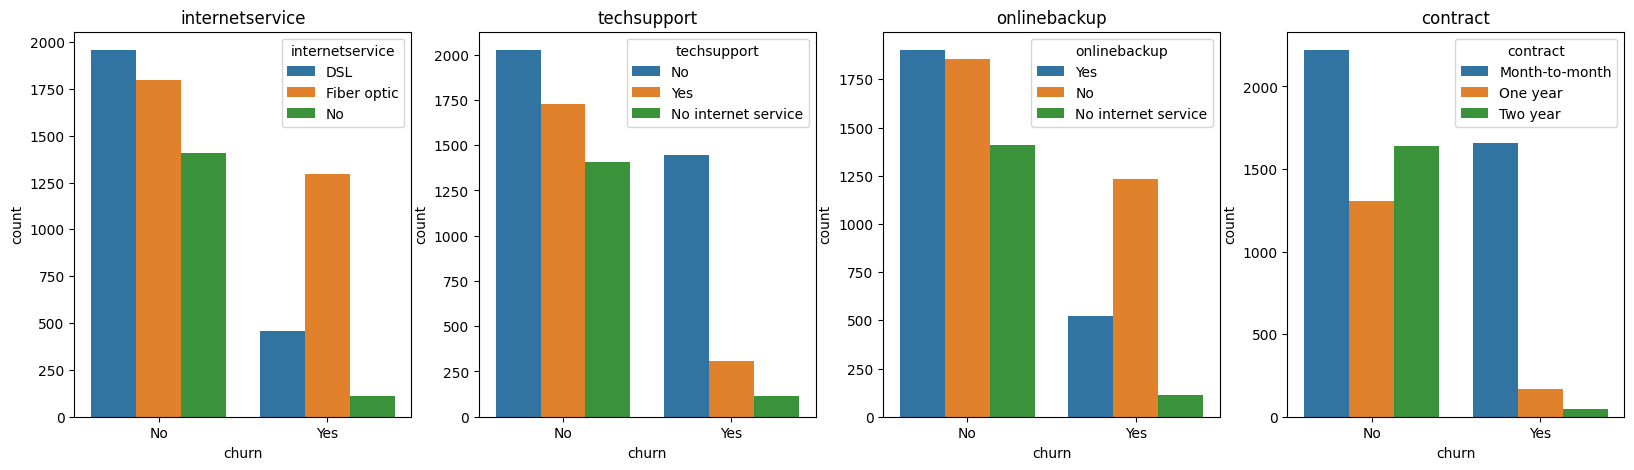

In [ ]:
cols = ['internetservice', 'techsupport' , 'onlinebackup', 'contract']

plt.figure(figsize=(20,5))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x='churn', hue=str(col), data=df1)
    ax.set_title(f'{col}')

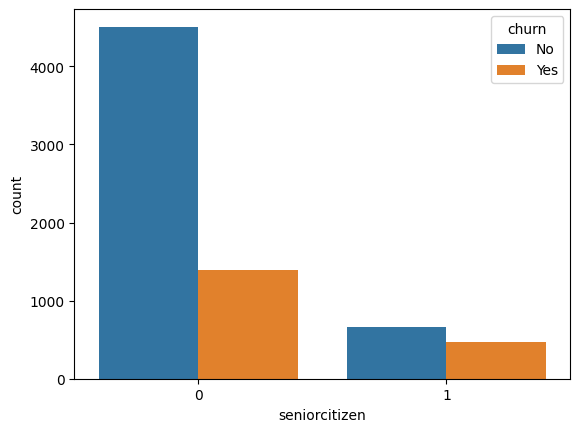

In [84]:
# customers who are Senior Citizens are more likely to churn due to unfamiliarity with technology or fixed incomes.

sns.countplot(x='seniorcitizen', hue='churn', data=df1);

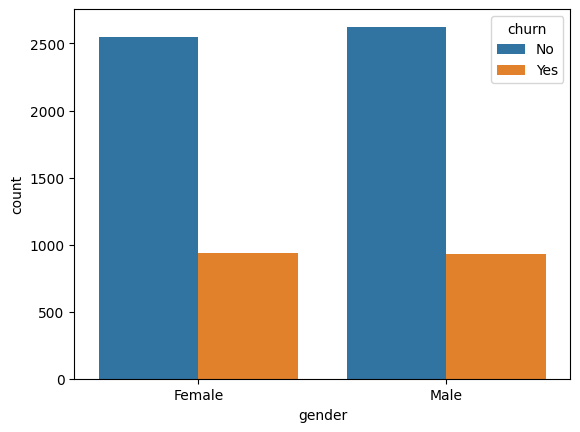

In [ ]:
# gender has no significant impact on churn rates.

sns.countplot(x='gender', hue='churn', data=df1);

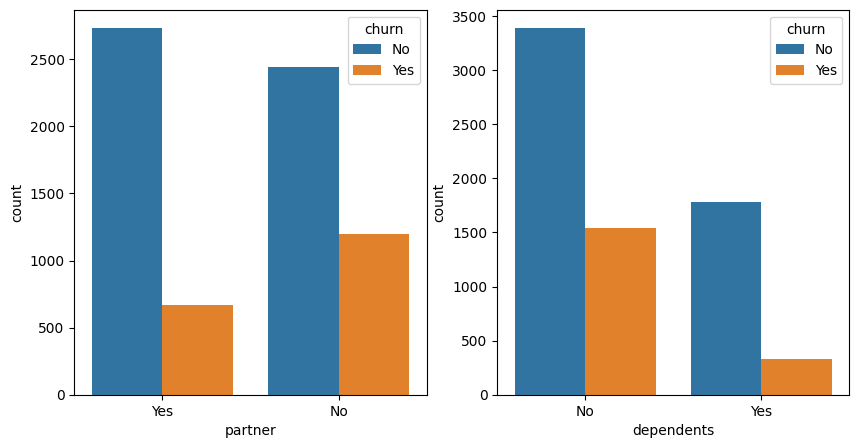

In [99]:
# customers with Dependents or a Partner are less likely to churn because they may rely on the service for family needs.

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='partner', hue='churn', data=df1);

plt.subplot(1, 2, 2)
sns.countplot(x='dependents', hue='churn', data=df1);

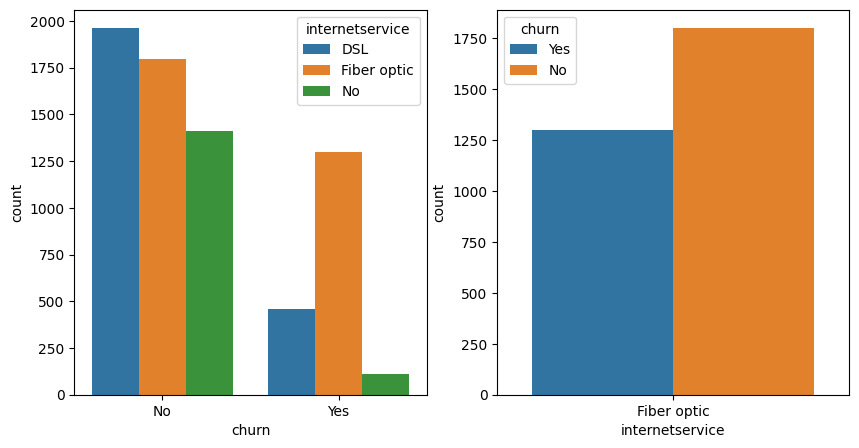

In [120]:
# customers with InternetService are less likely to churn since internet is often an essential utility.
# FIBER OPTIC

aux = df1[df1['internetservice'] == 'Fiber optic']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='churn', hue='internetservice', data=df1);

plt.subplot(1, 2, 2)
sns.countplot(hue='churn', x='internetservice', data=aux);

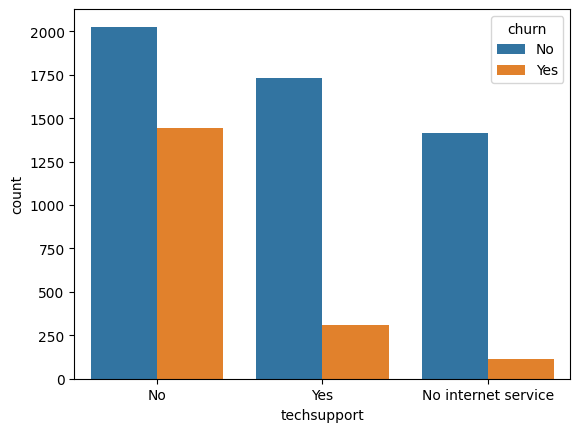

In [114]:
# customers who lack additional services like TechSupport are more likely to churn because they may feel the service is incomplete or they are not receiving enough value.

sns.countplot(x='techsupport', hue='churn', data=df1);

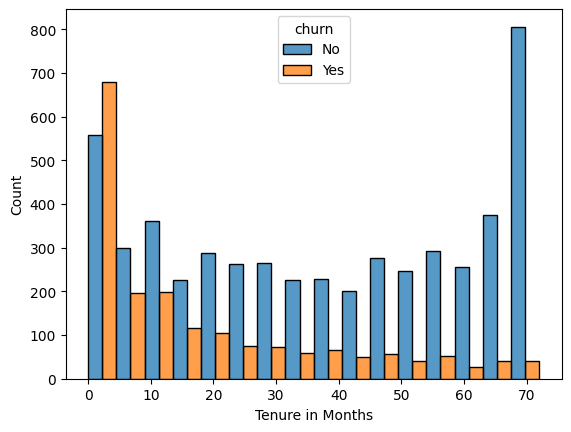

In [119]:
# customers with shorter tenure are more likely to churn because they have not yet developed loyalty to the company.

ax = sns.histplot(x = 'tenure', hue = 'churn', data = df1, multiple='dodge');
ax.set(xlabel="Tenure in Months", ylabel = "Count");

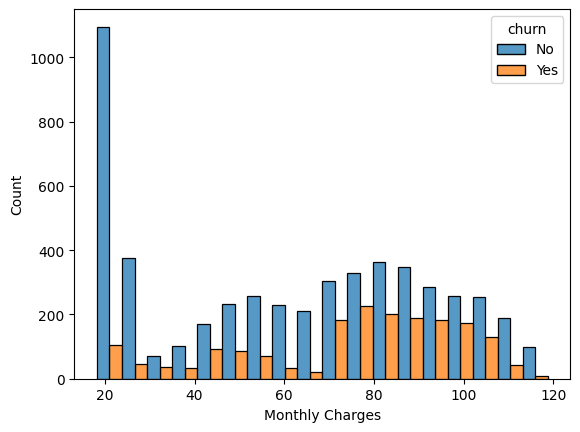

In [125]:
# customers with higher MonthlyCharges are more likely to churn due to perceived overpricing or financial burden.

ax1 = sns.histplot(x='monthlycharges', hue='churn', data=df1, multiple='dodge');
ax1.set(xlabel='Monthly Charges', ylabel='Count');

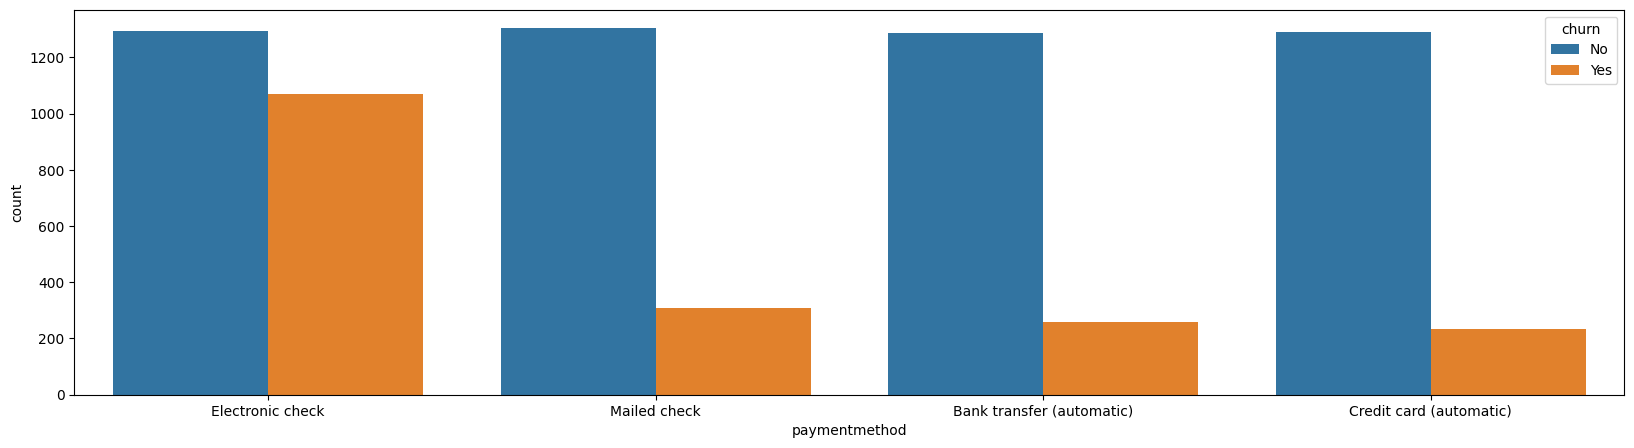

In [133]:
# customers paying via Credit Card or Bank Transfer are less likely to churn due to more consistent and automated payments.

plt.figure(figsize=(20, 5))
sns.countplot(x='paymentmethod', hue='churn', data=df1);

In [143]:
X_categorical = df1.drop(columns=['customerid', 'churn'])
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

y = df1['churn']

chi_scores = chi2(X_categorical, y)
p_values = pd.Series(chi_scores[1], index=X_categorical.columns)
p_values = p_values.sort_values()

print("P-Values for Features:")
print(p_values.head(10))

P-Values for Features:
tenure                                  0.000000e+00
monthlycharges                          0.000000e+00
contract_Two year                      2.905390e-108
paymentmethod_Electronic check          9.760677e-95
internetservice_Fiber optic             1.984260e-83
techsupport_No internet service         2.849642e-64
streamingmovies_No internet service     2.849642e-64
streamingtv_No internet service         2.849642e-64
internetservice_No                      2.849642e-64
onlinesecurity_No internet service      2.849642e-64
dtype: float64


# 2.0 data preparation

In [237]:
df2 = df1.copy()

In [238]:
# label encoder for categorical

le = preprocessing.LabelEncoder()
df2_cat = categorical.apply(le.fit_transform)
df2_cat.head()

,gender,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,churn
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


In [239]:
# merge

finaldf = pd.merge(numerical, df2_cat, left_index=True, right_index=True)
finaldf.head()

,customerid,totalcharges,monthlycharges,seniorcitizen,tenure,gender,partner,dependents,phoneservice,multiplelines,...,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,churn
0,7590-VHVEG,29.85,29.85,0,1,0,1,0,0,1,...,0,2,0,0,0,0,0,1,2,0
1,5575-GNVDE,1889.50,56.95,0,34,1,0,0,1,0,...,2,0,2,0,0,0,1,0,3,0
2,3668-QPYBK,108.15,53.85,0,2,1,0,0,1,0,...,2,2,0,0,0,0,0,1,3,1
3,7795-CFOCW,1840.75,42.30,0,45,1,0,0,0,1,...,2,0,2,2,0,0,1,0,0,0
4,9237-HQITU,151.65,70.70,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,1,2,1


## 2.1 split into train and test dataset

In [240]:
finaldf = finaldf.dropna()
finaldf = finaldf.drop(['customerid'], axis=1)

X = finaldf.drop(['churn'], axis=1)
y = finaldf['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [250]:
X_test.head()

,totalcharges,monthlycharges,seniorcitizen,tenure,gender,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod
2481,1501.75,25.00,1,61,1,1,0,1,2,2,1,1,1,1,1,1,2,0,0
6784,465.85,24.70,0,19,0,0,0,1,2,2,1,1,1,1,1,1,0,0,0
6125,1359.00,102.25,0,13,1,1,0,1,2,1,0,0,2,0,2,2,0,1,1
3052,2030.75,55.05,0,37,1,1,0,1,2,0,2,0,0,0,0,0,0,1,3
4099,161.45,29.45,0,6,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0


### 2.1.1 oversample

In [241]:
oversample = SMOTE(k_neighbors=5)
X_s, y_s = oversample.fit_resample(X_train, y_train)
X_train, y_train = X_s, y_s

In [242]:
y_train.value_counts()

churn
0    3452
1    3452
Name: count, dtype: int64

# 3.0 model training

In [243]:
rf = RandomForestClassifier(random_state=42)
model_rf = rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)
print(accuracy_score(pred_rf, y_test))

0.7703576044808272


In [244]:
lr = LogisticRegression()
model_lr = lr.fit(X_train, y_train)

pred_lr = model_lr.predict(X_test)
print(accuracy_score(pred_lr, y_test))

0.7509694097371823


# 4.0 model production

In [249]:
pickle.dump(model_rf, open('/Users/raphael/Documents/repos/bank_churn/model/model_churn.pkl', 'wb'))

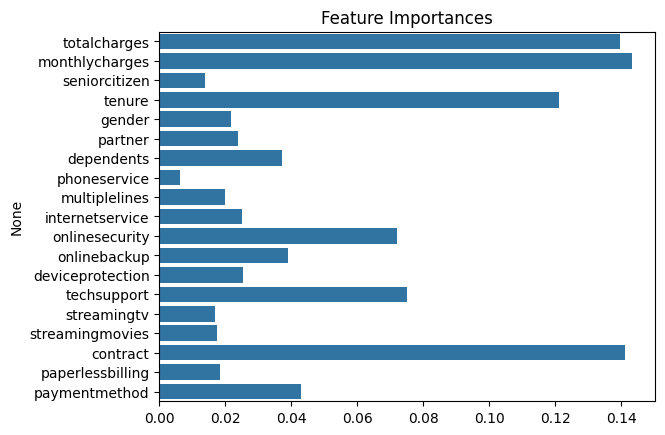

In [247]:
importances = model_rf.feature_importances_
feature_names = X_train.columns
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances')
plt.show()